# 1. Importing Libraries

In [1886]:
import pandas as pd 
import numpy as np 
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
import seaborn as sns 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from BorutaShap import BorutaShap
from imblearn.combine import SMOTEENN
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, log_loss, cohen_kappa_score, plot_confusion_matrix, PrecisionRecallDisplay
from statsmodels.stats.diagnostic import lilliefors
import math
from feature_engine import transformation as vt
from matplotlib.colors import ListedColormap

# 2. Reading Data

In [1822]:
#this function is to read, transform and join 2 data frame

def read_features():
    path = 'secom.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['feature_'+str(x+1) for x in range(len(df.columns))]
    return df



def read_target():
    path = 'secom_labels.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['status','timestamp']
    df['timestamp'] = pd.to_datetime(df['timestamp'],dayfirst=True)
    return df

#for the testing purporse, trim to remain first 100 rows only
X = read_features()
y = read_target().iloc[:,0]

In [1823]:
#Row & Columns of Features 
X.shape

(1567, 590)

# 3. Splitting Training & Testing Data

In [1824]:
#Splitting the Data: 80% Training, 20% Testing Data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1,stratify=y)

In [1825]:
#Rows and Columns of X_Train DF
x_train.shape

(1253, 590)

In [1826]:
#Rows and Columns of X_Train DF
x_test.shape

(314, 590)

# 4. Reducing Dimensionality

## 4.1. Remove duplicated Columns

In [1827]:
#Function for finding and removing duplicated columns (features)
def remove_duplicated_columns(df):
    dict_duplicate_pair = {}
    dict_duplicate_matches = {}
    list_duplicate = []
    to_remove = []
    for i in range(0, len(df.columns)):
        l = []
        for j in range(i+1,len(df.columns)):
            dict_duplicate_pair[str(i+1)+';'+str(j+1)] = df.iloc[:,i].equals(df.iloc[:,j])
            if df.iloc[:,i].equals(df.iloc[:,j]) == True:
                if j not in list_duplicate:
                    l.append(j)
                    to_remove.append('feature_'+str(j+1))
                list_duplicate.append(i)
                list_duplicate.append(j)
        if len(l)!=0:
            dict_duplicate_matches[i] = l


    df_duplicate_pair = pd.DataFrame.from_dict(dict_duplicate_pair, orient='index')
    df_duplicate_pair.columns=['duplicate']

    df_duplicate_matches = pd.DataFrame.from_dict(dict_duplicate_matches, orient='index')

    
    df = df.drop(columns=to_remove, axis = 1)

    return df

In [1828]:
#Using Function on x_train & printing new shape of dataframe after transformation 
x_train = remove_duplicated_columns(x_train)
x_train.shape

(1253, 486)

## 4.2. Removing Features with Constant Volatility

In [1829]:
#Defining function to find and remove features with zero standard deviation 
def remove_constant_volatility(df):
    df_EDA= df.describe().T
    df_EDA= df_EDA[df_EDA["std"] == 0]
    df = df.drop(axis=1, columns=df_EDA.index)
    return df

In [1830]:
#Using Function on x_train & printing new shape of dataframe after transformation 
x_train = remove_constant_volatility(x_train)
x_train.shape

(1253, 474)

## 4.3. Remove Features with high % of Missing Values

In [1831]:
#Defining function to remove features with a given % of missing values 
def remove_cols_with_high_pct_null(df, null_threshold):
    list_column_with_pct_null = pd.concat([df.isnull().sum(), df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    list_column_with_pct_null= list_column_with_pct_null[list_column_with_pct_null["Percentage (%)"] >= null_threshold]
    df = df.drop(axis=1, columns=list_column_with_pct_null.index)
    return df

In [1832]:
#Using Function on x_train & printing new shape of dataframe after transformation 
x_train = remove_cols_with_high_pct_null(x_train, 0.8)
x_train.shape

(1253, 466)

# 5. Outlier & Missing Value Treatment

In [1833]:
#Definition of Functiom
def outlier_clamp(df):
    for col in df.columns:
        ll_col = df[col].mean() - 2 * df[col].std()
        ul_col = df[col].mean() + 2 * df[col].std()
        df[col] = np.where(df[col]>ul_col,ul_col,np.where(df[col]<ll_col,ll_col,df[col]))
    return df

In [1834]:
x_train = outlier_clamp(x_train)

In [1835]:
#KNN only distance
def knndistance(df):
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns= df.columns)
    #KNN Imputation 
    knn = KNNImputer(n_neighbors=5, weights='distance')
    df = pd.DataFrame(knn.fit_transform(df), columns=df.columns)
    #Reverse Scaling
    df = pd.DataFrame(scaler.inverse_transform(df), columns= df.columns)
    return df  

In [1836]:
x_train = knndistance(x_train)

#Function to drop Outliers and impute Missing Values with KNN 
def outlierknn(df):
    #Outlier treatment first:
    for col in df.columns:
          ll_col = df[col].mean() - 3 * df[col].std()
          ul_col = df[col].mean() + 3 * df[col].std()
          df[col] = np.where(df[col]>ul_col,np.NaN,np.where(df[col]<ll_col,np.NaN,df[col]))
    #Scaling data 
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns= df.columns)
    #KNN Imputation
    knn = KNNImputer(n_neighbors=3, weights='distance')
    df = pd.DataFrame(knn.fit_transform(df), columns=df.columns)
    #Reverse Scaling
    df = pd.DataFrame(scaler.inverse_transform(df), columns= df.columns)
    return df  

#Using function above on x_train
x_train = outlierknn(x_train)

# 6. Feature Selection

In [1837]:
#This is BorutaShap with TENTATIVE features

#list_method=['shap','gini']

def BorutaShap_FS (X, y,method_option) :
    #modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, class_weight='balanced_subsample', max_depth=5, random_state=100)
    modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, max_depth=5, random_state=100)

    # define model for resp. classifier
    modelshap.fit(X,y)
    feature_names = np.array(X.columns)
    # define Boruta Sahp feature selection method
    feature_selector = BorutaShap(model=modelshap,
                              importance_measure=method_option,
                              classification=True)  # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False, verbose = False,random_state=100)  
    #feature_selector.plot(which_features='accepted',figsize=(20,10))
    tentative=X.loc[:,feature_selector.tentative]
    selected=feature_selector.Subset()
    selten=pd.concat([selected,tentative],axis=1)
    # call transform() on X to filter it down to selected features
    return  selten

In [1838]:
x_train = BorutaShap_FS(x_train,y_train,'shap')

  0%|          | 0/100 [00:00<?, ?it/s]

In [1839]:
#Shape of x_train after Feature Selection
x_train.shape

(1253, 18)

In [1840]:
#Correlation Matrix of Remaining Features
x_train.corr()

,feature_478,feature_206,feature_60,feature_283,feature_34,feature_66,feature_300,feature_342,feature_124,feature_299,feature_349,feature_65,feature_435,feature_164,feature_332,feature_22,feature_442,feature_511
feature_478,1.000000,0.991267,0.225665,0.104271,0.088570,0.070453,-0.000140,0.972450,-0.016543,-0.001226,0.054330,0.001830,0.013147,-0.000958,-0.074695,-0.087549,0.069783,0.130019
feature_206,0.991267,1.000000,0.222141,0.109624,0.086516,0.064311,0.003006,0.971290,-0.013497,0.000270,0.058743,-0.002962,0.015505,0.000477,-0.077133,-0.085964,0.078001,0.130955
feature_60,0.225665,0.222141,1.000000,0.234155,0.151461,-0.367557,0.124491,0.213030,0.058482,0.101985,0.263898,-0.442174,0.154792,0.094562,-0.012312,-0.059998,0.116086,0.275770
feature_283,0.104271,0.109624,0.234155,1.000000,0.015524,0.025666,0.056296,0.108212,0.018455,0.008004,0.148143,0.010418,0.066486,0.001214,-0.010994,-0.068091,0.038029,0.150484
feature_34,0.088570,0.086516,0.151461,0.015524,1.000000,0.076105,-0.004521,0.095850,0.082126,-0.030413,0.079629,0.069285,0.014279,-0.031891,0.018617,-0.054129,-0.171898,0.081629
feature_66,0.070453,0.064311,-0.367557,0.025666,0.076105,1.000000,0.128358,0.078145,-0.075159,0.097396,0.038244,0.929922,0.121280,0.075921,-0.102256,0.082394,0.000345,0.138749
feature_300,-0.000140,0.003006,0.124491,0.056296,-0.004521,0.128358,1.000000,0.006598,-0.040784,0.729528,0.082498,0.111564,0.907933,0.671424,-0.058130,0.421756,-0.014783,0.147169
feature_342,0.972450,0.971290,0.213030,0.108212,0.095850,0.078145,0.006598,1.000000,-0.028372,0.001610,0.051204,0.015313,0.014011,0.002768,-0.098062,-0.080120,0.069584,0.129544
feature_124,-0.016543,-0.013497,0.058482,0.018455,0.082126,-0.075159,-0.040784,-0.028372,1.000000,-0.011607,0.015073,-0.070255,-0.007802,-0.007033,0.082148,-0.074747,0.028177,0.027688
feature_299,-0.001226,0.000270,0.101985,0.008004,-0.030413,0.097396,0.729528,0.001610,-0.011607,1.000000,0.052638,0.079370,0.872670,0.988125,-0.039690,0.404651,-0.048967,0.085206


Text(0.5, 1.0, 'Correlation of remaining Features')

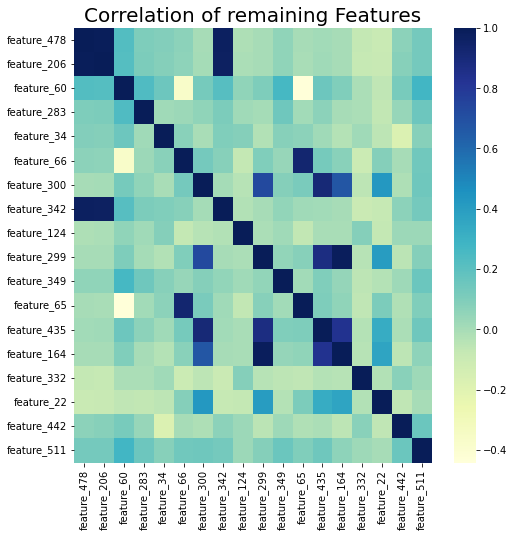

In [1841]:
#Heatmap of Correlation of Remaining Feaures 
plt.rcParams['figure.figsize'] = (8, 8) #this is to set the size for the plot, making it bigger
sns.heatmap(x_train.corr(), cmap = "YlGnBu")
plt.title('Correlation of remaining Features', fontsize = 20)

# 7. Multicolinearity Treatment

In [1842]:
#Remove the highly collinear features from data
def remove_collinear_features(x, threshold):


    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                #Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [1843]:
x_train=remove_collinear_features(x_train, 0.7)
x_train.shape

(1253, 12)

Text(0.5, 1.0, 'Correlation of remaining Features')

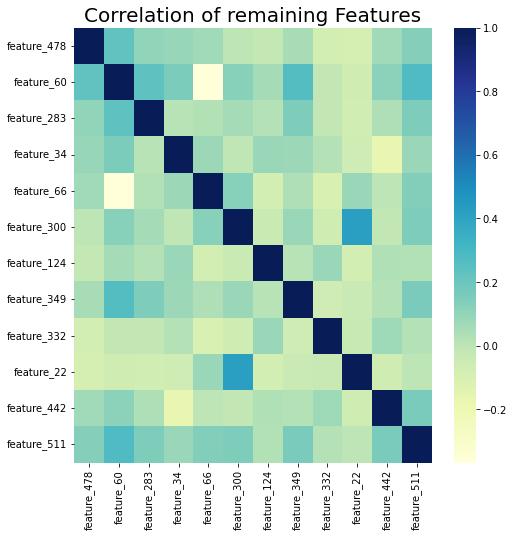

In [1844]:
#Heatmap of Correlation of Remaining Feaures 
plt.rcParams['figure.figsize'] = (8, 8) #this is to set the size for the plot, making it bigger
sns.heatmap(x_train.corr(), cmap = "YlGnBu")
plt.title('Correlation of remaining Features', fontsize = 20)

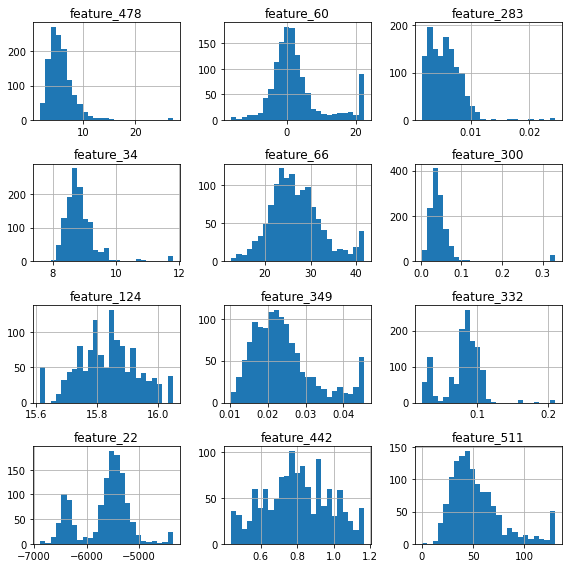

In [1845]:
#Histograms remaining Features 
x_train.hist(bins=25)
plt.tight_layout()
plt.show()

In [1846]:
#Normality Test
for i in x_train.columns:
    print(i)
    statistic, pvalue = lilliefors(x_train[[i]])
    print('statistic=%.3f, p=%.3f\n' % (statistic, pvalue))
    if pvalue > 0.05:
        print('Probably Gaussian')
    else:
        print('Probably not Gaussian')

feature_478
statistic=0.118, p=0.001

Probably not Gaussian
feature_60
statistic=0.170, p=0.001

Probably not Gaussian
feature_283
statistic=0.074, p=0.001

Probably not Gaussian
feature_34
statistic=0.142, p=0.001

Probably not Gaussian
feature_66
statistic=0.055, p=0.001

Probably not Gaussian
feature_300
statistic=0.241, p=0.001

Probably not Gaussian
feature_124
statistic=0.045, p=0.001

Probably not Gaussian
feature_349
statistic=0.102, p=0.001

Probably not Gaussian
feature_332
statistic=0.157, p=0.001

Probably not Gaussian
feature_22
statistic=0.150, p=0.001

Probably not Gaussian
feature_442
statistic=0.037, p=0.001

Probably not Gaussian
feature_511
statistic=0.112, p=0.001

Probably not Gaussian


# 8. Balancing

In [1847]:
#Function SMOTEENN
def sampling(X_train, y_train):
    sampler = SMOTEENN(random_state=100)
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

# X_train, y_train = sampling(X_train, y_train,'SMOTE')
# X_train.shape

In [1848]:
x_train, y_train = sampling(x_train, y_train)

In [1849]:
x_train.shape

(1593, 12)

In [1850]:
y_train.shape

(1593,)

# 9. Modeling

In [1851]:
#Turning y_train to categorical, since Naive Bayes works better on categorical data
y_train = pd.Categorical(y_train)
y_train = pd.DataFrame(y_train)

In [1852]:
#Model and Model Evaluation
gnb = GaussianNB()
gnb.fit(x_train, y_train)
# make predictions
expected = y_train
predicted = gnb.predict(x_train)
# summarize the fit of the gnb
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))


              precision    recall  f1-score   support

          -1       0.62      0.88      0.73       686
           1       0.87      0.60      0.71       907

    accuracy                           0.72      1593
   macro avg       0.75      0.74      0.72      1593
weighted avg       0.76      0.72      0.72      1593

[[604  82]
 [365 542]]


In [1853]:
cf_matrix = confusion_matrix(expected, predicted)
sensitivity = cf_matrix[1][1] / ( cf_matrix[1][1] + cf_matrix[1][0] )
sensitivity

0.597574421168688

# 10. Test Data

In [1854]:
#1. Remove Duplicated Columns 
x_test = remove_duplicated_columns(x_test)
x_test.shape

(314, 480)

In [1855]:
#2. Remove Constant Volalitily
x_test = remove_constant_volatility(x_test)
x_test.shape

(314, 468)

In [1856]:
#3. Remove High % of NA
x_test = remove_cols_with_high_pct_null(x_test, 0.8)
x_test.shape

(314, 460)

In [1857]:
#4. Treat Outliers and Missing Values
## IF NA + KNN
#x_test= outlierknn(x_test)
## IF CLAMP + KNN
x_test = outlier_clamp(x_test)
x_test = knndistance(x_test)

In [1858]:
#5. Take the same Columns as in train data 
columns_list = x_train.columns
x_test = x_test.loc[:,columns_list]
x_test.shape

(314, 12)

In [1859]:
#6. Change Target Variable to Categorical
y_test = pd.Categorical(y_test)
y_test = pd.DataFrame(y_test)

In [1860]:
exp_test = y_test
pred_test = gnb.predict(x_test)
# summarize the fit of the gnb
print(metrics.classification_report(exp_test, pred_test))
print(metrics.confusion_matrix(exp_test, pred_test))

              precision    recall  f1-score   support

          -1       0.96      0.83      0.89       293
           1       0.18      0.52      0.27        21

    accuracy                           0.81       314
   macro avg       0.57      0.68      0.58       314
weighted avg       0.91      0.81      0.85       314

[[243  50]
 [ 10  11]]


In [1861]:
cf_matrix_test = confusion_matrix(exp_test, pred_test)
sensitivity_test = cf_matrix_test[1][1] / ( cf_matrix_test[1][1] + cf_matrix_test[1][0] )
sensitivity_test

0.5238095238095238

In [1862]:
#Accuracy score
accuracy_score(exp_test, pred_test)

0.8089171974522293

In [1863]:
#Recall score
recall_score(exp_test, pred_test)

0.5238095238095238

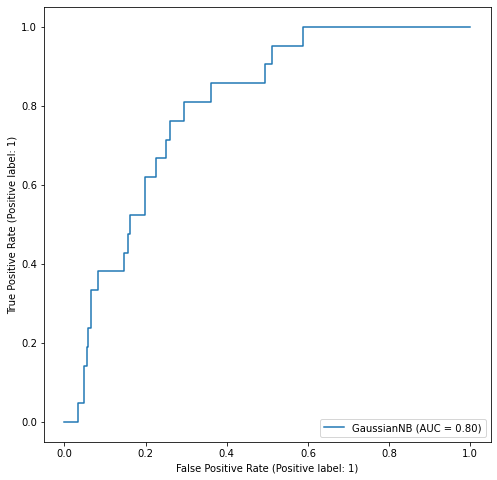

In [1864]:
# ROC curve
metrics.RocCurveDisplay.from_estimator(gnb, x_test, y_test)
plt.show()

# 11. Grid Search & Cross Validation

## 11.1. Grid Search

In [1865]:
#Gridsearch
##Define Grid Search Parameters 
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
#Hyperparameter Tune using Training Data 
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(x_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


/Users/arasdirekoglu/opt/anaconda3/envs/dscience/lib/python3.9/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arasdirekoglu/opt/anaconda3/envs/dscience/lib/python3.9/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arasdirekoglu/opt/anaconda3/envs/dscience/lib/python3.9/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arasdirekoglu/opt/anaconda3/envs/dscience/lib/python3.9/site-packages/sklearn/utils/validatio

GridSearchCV(cv=10, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.848035...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             verbose=1)

In [1866]:
#Print Best estimator
print(nbModel_grid.best_estimator_, "is the best estimator")

GaussianNB(var_smoothing=4.328761281083062e-05) is the best estimator


In [1867]:
#Data Frame Grid Search Results 
pd.DataFrame(nbModel_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003930,0.001357,0.002054,0.001312,1.0,{'var_smoothing': 1.0},0.56250,0.66875,0.65625,0.578616,0.591195,0.654088,0.584906,0.616352,0.572327,0.603774,0.608876,0.036393,100
1,0.002126,0.000453,0.001094,0.000188,0.811131,{'var_smoothing': 0.8111308307896871},0.56875,0.66875,0.65625,0.578616,0.597484,0.654088,0.584906,0.622642,0.578616,0.603774,0.611388,0.034888,99
2,0.001979,0.000472,0.001009,0.000084,0.657933,{'var_smoothing': 0.657933224657568},0.58125,0.66875,0.65625,0.578616,0.603774,0.654088,0.591195,0.622642,0.578616,0.603774,0.613895,0.032818,96
3,0.001714,0.000191,0.001006,0.000302,0.53367,{'var_smoothing': 0.533669923120631},0.58125,0.66875,0.66250,0.578616,0.603774,0.654088,0.597484,0.622642,0.578616,0.603774,0.615149,0.033282,93
4,0.001600,0.000231,0.000872,0.000024,0.432876,{'var_smoothing': 0.43287612810830584},0.58125,0.66875,0.66250,0.591195,0.603774,0.654088,0.603774,0.622642,0.578616,0.603774,0.617036,0.031777,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.001476,0.000192,0.000857,0.000048,0.0,{'var_smoothing': 2.310129700083158e-09},0.72500,0.73125,0.73125,0.723270,0.710692,0.723270,0.710692,0.729560,0.729560,0.704403,0.721895,0.009290,57
96,0.001444,0.000120,0.000839,0.000032,0.0,{'var_smoothing': 1.873817422860387e-09},0.71875,0.73125,0.72500,0.723270,0.716981,0.723270,0.704403,0.729560,0.729560,0.710692,0.721274,0.008247,58
97,0.001397,0.000118,0.000827,0.000026,0.0,{'var_smoothing': 1.519911082952933e-09},0.71250,0.71875,0.71875,0.723270,0.710692,0.723270,0.704403,0.729560,0.729560,0.710692,0.718145,0.008035,60
98,0.001435,0.000151,0.000838,0.000031,0.0,{'var_smoothing': 1.2328467394420635e-09},0.71250,0.71875,0.71875,0.723270,0.710692,0.723270,0.704403,0.729560,0.723270,0.710692,0.717516,0.007333,61


## 11.2. Cross Validation

In [1868]:
# Evaluation using Startified K Fold cross validation
cv = StratifiedKFold(n_splits=5)
scores = cross_val_score(nbModel_grid.best_estimator_, x_train, y_train, cv=cv, scoring = 'recall')
print(scores.mean())
# fit
nb=nbModel_grid.best_estimator_.fit(x_train, y_train)    
# predict
y_pred_test = nbModel_grid.best_estimator_.predict(x_test)
# View accuracy score
accuracyFinal = accuracy_score(y_test, y_pred_test)
print('Test Accuracy : ', accuracyFinal)

0.6648655212191124
Test Accuracy :  0.7738853503184714


In [1869]:
#Confusion Matrix & Classification Report of best estimator
print(metrics.confusion_matrix(y_test, y_pred_test))
print(metrics.classification_report(y_test, y_pred_test))

[[228  65]
 [  6  15]]
              precision    recall  f1-score   support

          -1       0.97      0.78      0.87       293
           1       0.19      0.71      0.30        21

    accuracy                           0.77       314
   macro avg       0.58      0.75      0.58       314
weighted avg       0.92      0.77      0.83       314



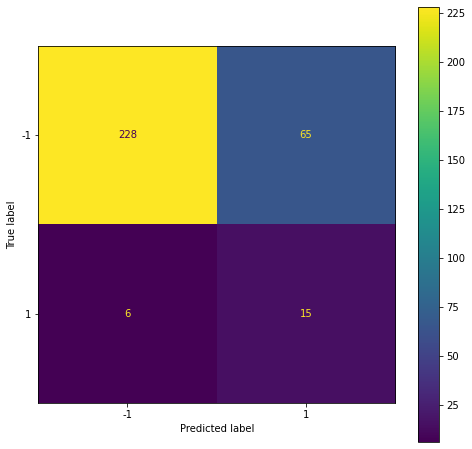

In [1870]:
# Plot confussion matrix
cm = confusion_matrix(y_test, y_pred_test, labels=nbModel_grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=nbModel_grid.classes_)
disp.plot()
plt.show()

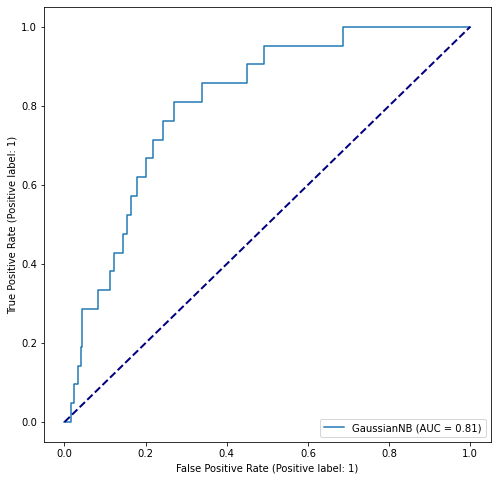

In [1889]:
# ROC curve
metrics.RocCurveDisplay.from_estimator(nbModel_grid.best_estimator_, x_test, y_test)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.show()

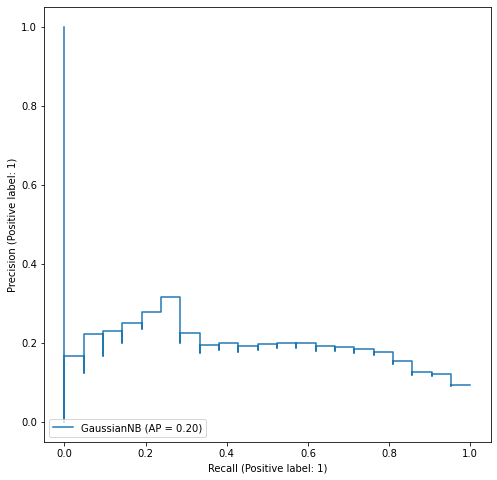

In [1887]:
#Precision / Recall
metrics.PrecisionRecallDisplay.from_estimator(nbModel_grid.best_estimator_, x_test, y_test)
plt.show()